In [13]:
import sys
sys.path.append('../scripts')  
from models import *
from df_handling import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import warnings
import statistics
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#unify all my data into one df
#load training datasets 
train1 = pd.read_csv('../data/fullfacts_emb.csv')
train2 = pd.read_csv('../data/greek_web_scraping_emb.csv')
train2_1 = pd.read_csv('../data/greek_web_scraping.csv')
train3 = pd.read_csv('../data/snopes2_emb.csv', nrows=1000)
train4 = pd.read_csv('../data/reuters_emb.csv')
train5  = pd.read_csv('../data/test1.csv')
train6  = pd.read_csv('../data/cyprus_factcheck_emb.csv')

train1 = unravel_df(train1, ['text_embedding'])
train2 = unravel_df(train2, ['text_embedding'])
train3 = unravel_df(train3, ['text_embedding'])
train4 = unravel_df(train4, ['text_embedding'])
train5 = unravel_df(train5, ['text_embedding'])
train6 = unravel_df(train6, ['text_embedding'])
train5.rename(columns={'text': 'claim', 'predict_label': 'label'}, inplace=True)

In [3]:
#find whick grek data is from greekhoaxes etc
train2_1 = train2_1[['id','url']]
train2_1['source'] = train2_1['url'].apply(lambda x: 'greekhoaxes' if "ellinikahoaxes" in x else ('factcheckgreek' if "factcheckgreek" in x else None))
train2 = pd.merge(train2, train2_1[['id','source']], on='id', how='inner')

In [4]:
#assign a source for the rest of the data
train1['source'] = 'fullfacts'
train3['source'] = 'snopes'
train4['source'] = 'reuters'
train5['source'] = 'postgres'
train6['source'] = 'cyprus'

In [5]:
#create a single dataframe
df_train = pd.concat([train1,train2,train3, train4, train5, train6], ignore_index=True)

#keep only 3 labels
df_train = df_train[df_train.label<=2]
df_train.reset_index(drop=True, inplace=True)

In [6]:
df_train.source.value_counts()

fullfacts         1377
snopes             759
reuters            378
factcheckgreek     307
greekhoaxes        219
postgres           148
cyprus             129
Name: source, dtype: int64

In [27]:
df_train.label.value_counts()

0.0    2023
1.0    1035
2.0     259
Name: label, dtype: int64

In [28]:
#only examine the false label
df_false = df_train[df_train.label==0]
df_false.reset_index(drop=True, inplace=True)

In [29]:
#only examine the true label
df_true = df_train[df_train.label==1]
df_true.reset_index(drop=True, inplace=True)

In [30]:
#only examine the missing_context label
df_miss = df_train[df_train.label==2]
df_miss.reset_index(drop=True, inplace=True)

In [31]:
#store our features for our TSNe analysis here

arr = [df_false.text_embedding[i] for i in range(len(df_false))]
source = [df_false.source[i] for i in range(len(df_false))]


arr2 = [df_true.text_embedding[i] for i in range(len(df_true))]
source2 = [df_true.source[i] for i in range(len(df_true))]


arr3 = [df_miss.text_embedding[i] for i in range(len(df_miss))]
source3 = [df_miss.source[i] for i in range(len(df_miss))]


arr = np.array(arr, dtype=np.float64)
arr2 = np.array(arr2, dtype=np.float64)
arr3 = np.array(arr3, dtype=np.float64)

In [32]:
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(arr)
tsne_features2 = m.fit_transform(arr2)
tsne_features3 = m.fit_transform(arr3)

  File "c:\Users\johnk\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


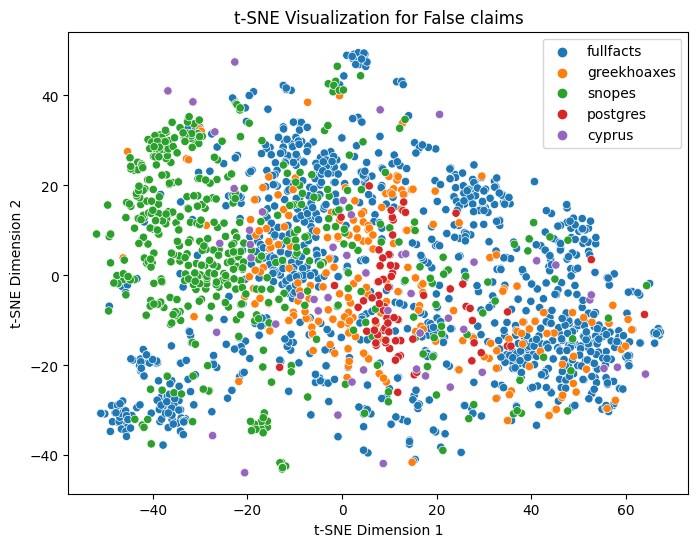

In [14]:
X = tsne_features[:,0]
y = tsne_features[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=source)
plt.title('t-SNE Visualization for False claims')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

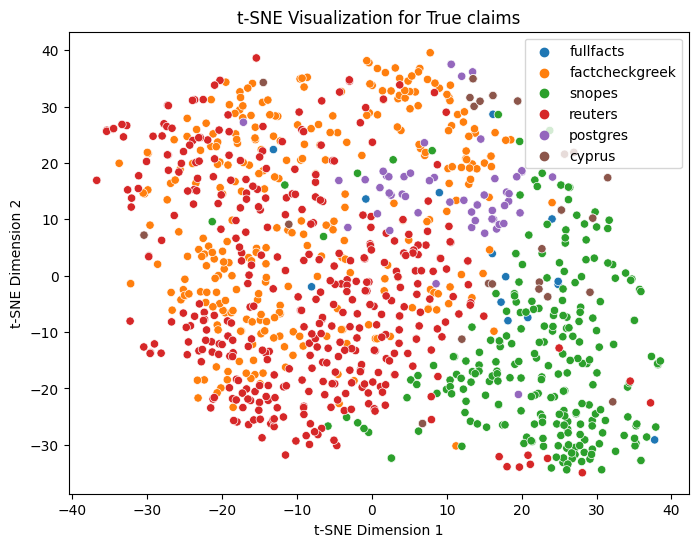

In [15]:
X = tsne_features2[:,0]
y = tsne_features2[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=source2)
plt.title('t-SNE Visualization for True claims')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

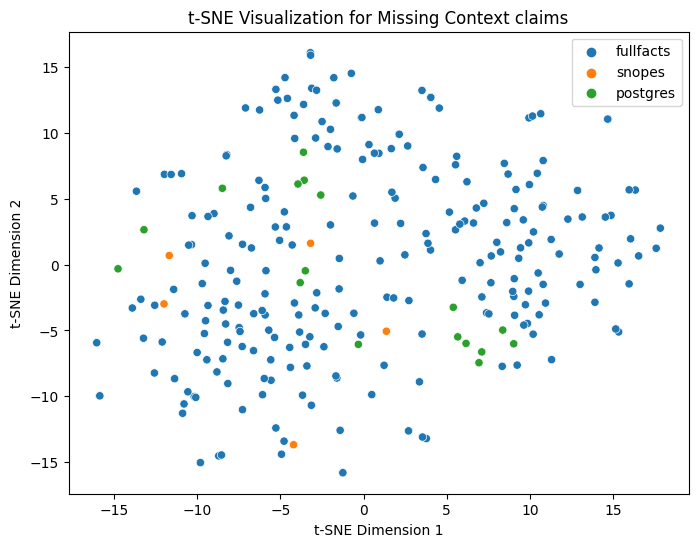

In [16]:
X = tsne_features3[:,0]
y = tsne_features3[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=source3)
plt.title('t-SNE Visualization for Missing Context claims')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [17]:
pca = PCA(n_components=2)
pca.fit(arr)
pca.fit(arr2)
pca.fit(arr3)
pca_false = pca.transform(arr)
pca_true = pca.transform(arr2)
pca_miss = pca.transform(arr3)

In [18]:
pca_false[:,0]

array([-0.16498035, -0.02453292, -0.11640709, ..., -0.02665573,
       -0.07627566, -0.02283923])

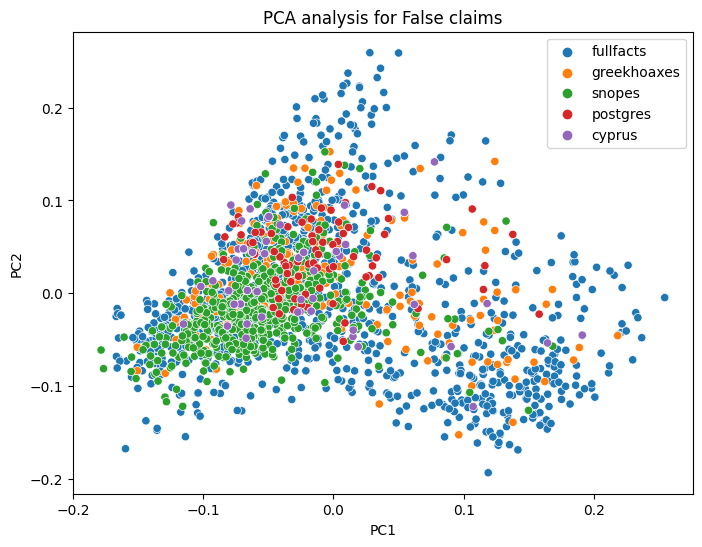

In [19]:



X = pca_false[:,0]
y = pca_false[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=source)
plt.title('PCA analysis for False claims')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

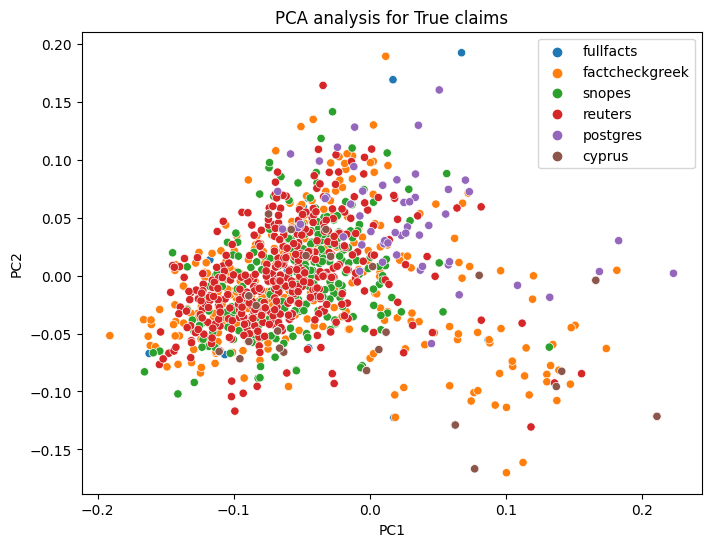

In [20]:
X = pca_true[:,0]
y = pca_true[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=source2)
plt.title('PCA analysis for True claims')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

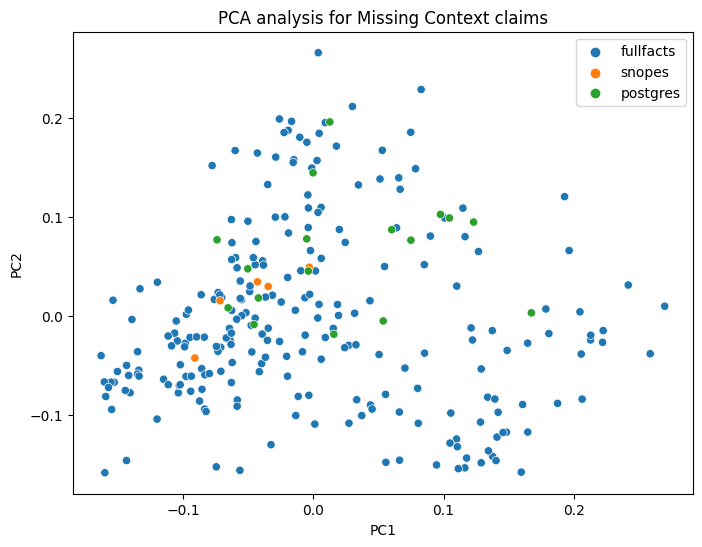

In [21]:
X = pca_miss[:,0]
y = pca_miss[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=source3)
plt.title('PCA analysis for Missing Context claims')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [9]:
test = df_train[df_train.source=='factcheckgreek']
test.shape

(307, 5)

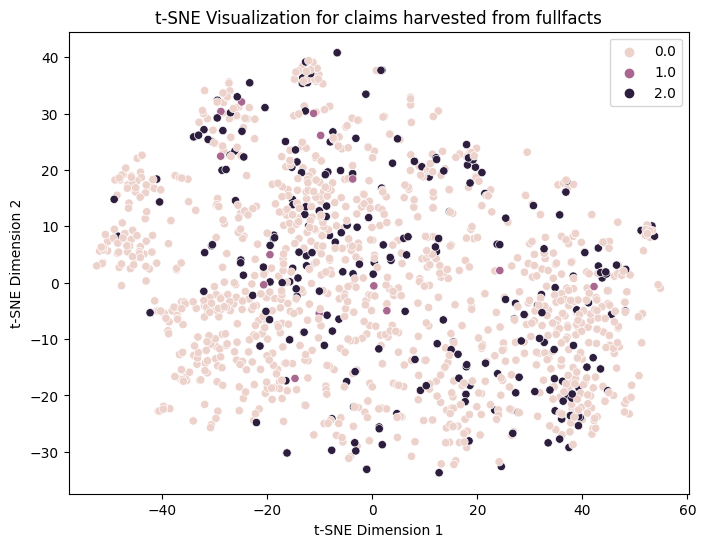

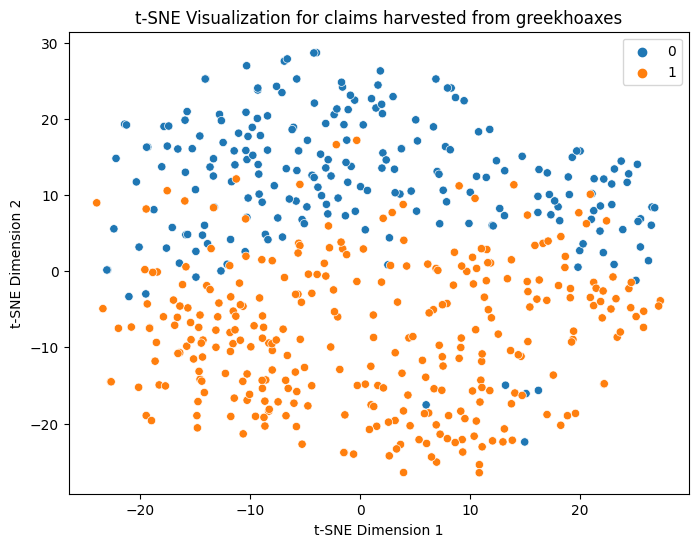

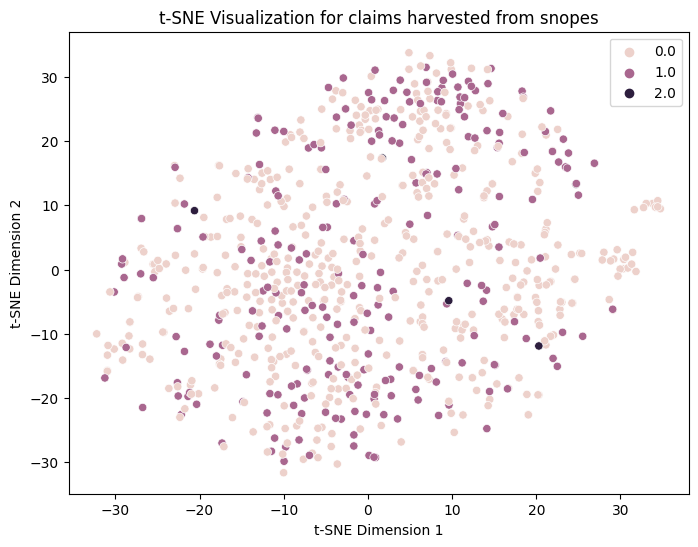

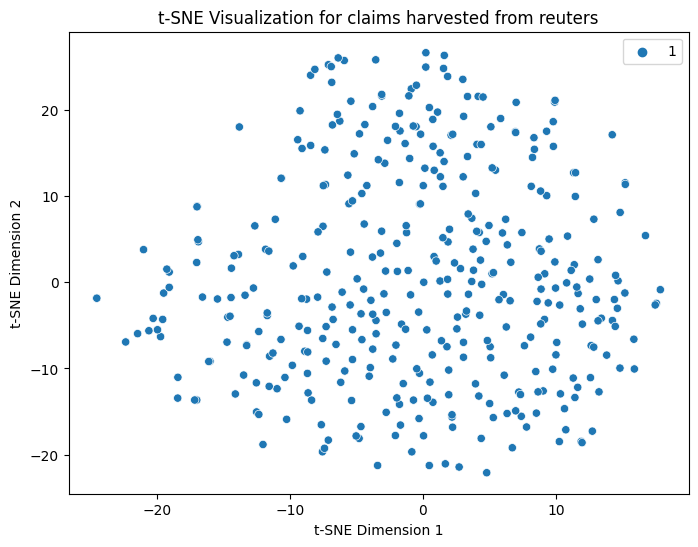

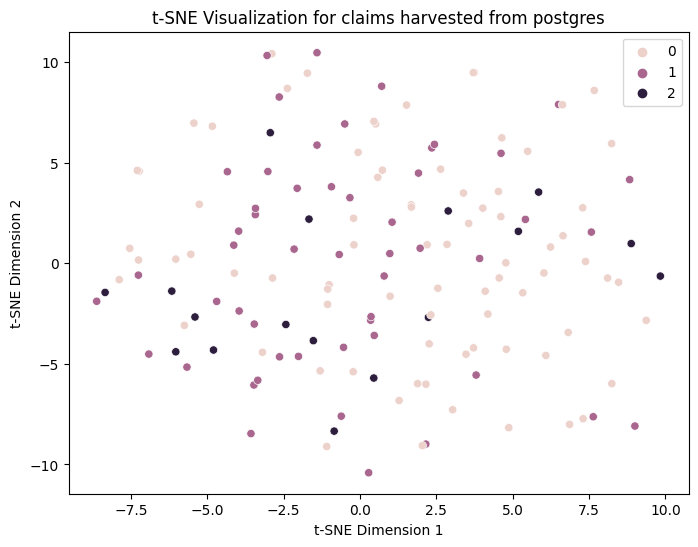

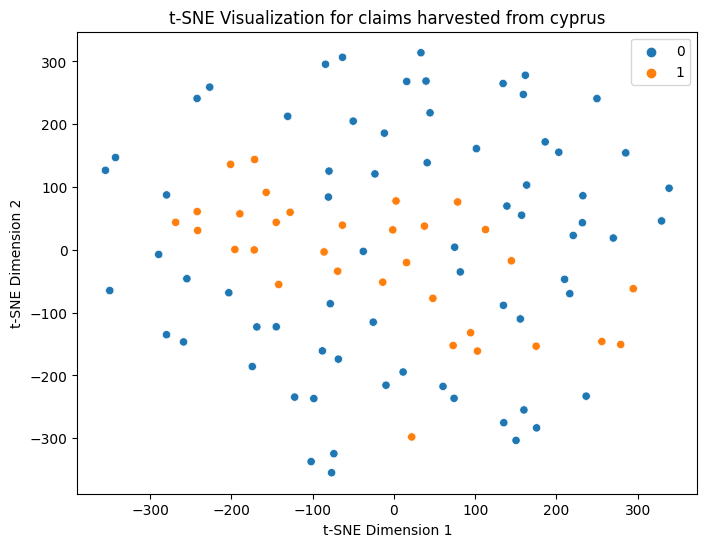

In [43]:
train_dfs = [train1, train2, train3, train4, train5, train6]


for df in train_dfs:

    df = df[df.label<=2]
    df.reset_index(drop=True, inplace=True)
    arr = [df.text_embedding[i] for i in range(len(df))]
    
    labels = [df.label[i] for i in range(len(df))]
    arr = np.array(arr, dtype=np.float64)
    tsne_features = m.fit_transform(arr)
    

    X = tsne_features[:,0]
    y = tsne_features[:,1]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X,y=y, hue=labels)
    plt.title(f"t-SNE Visualization for claims harvested from {df.source[0]}")
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


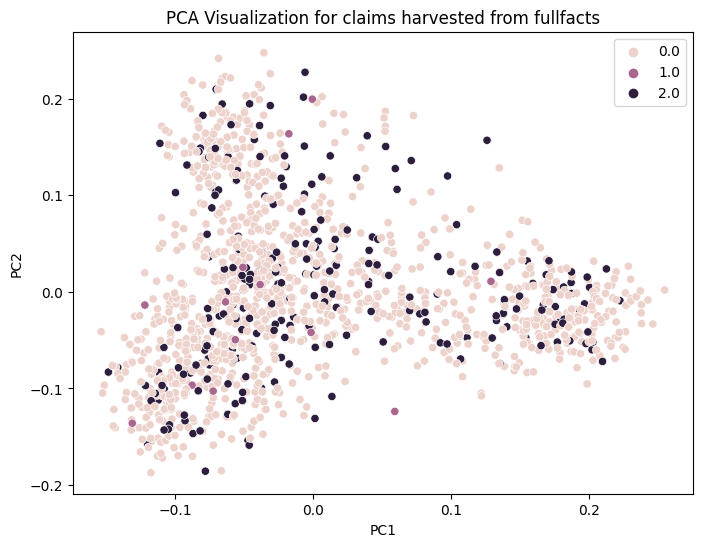

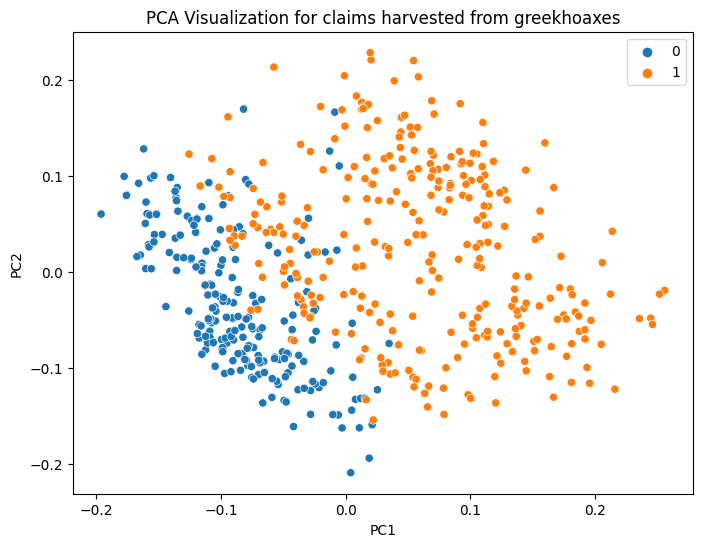

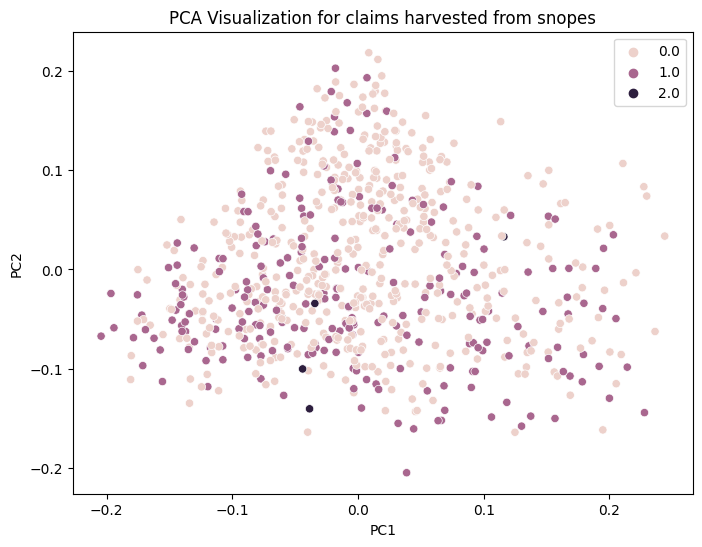

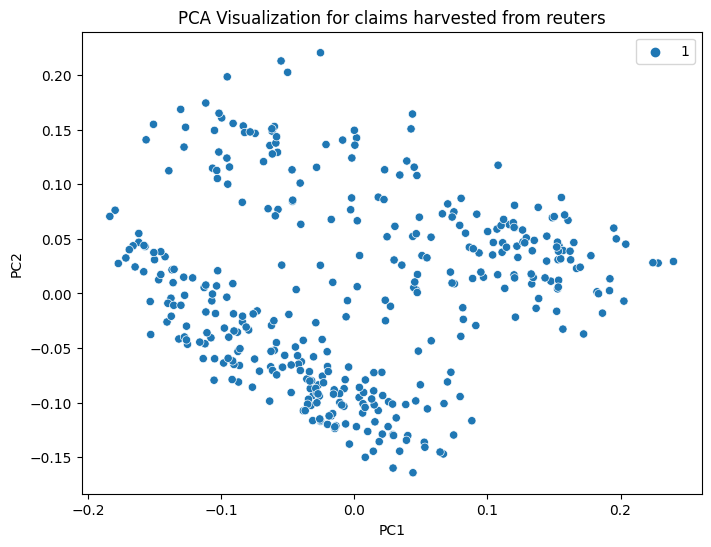

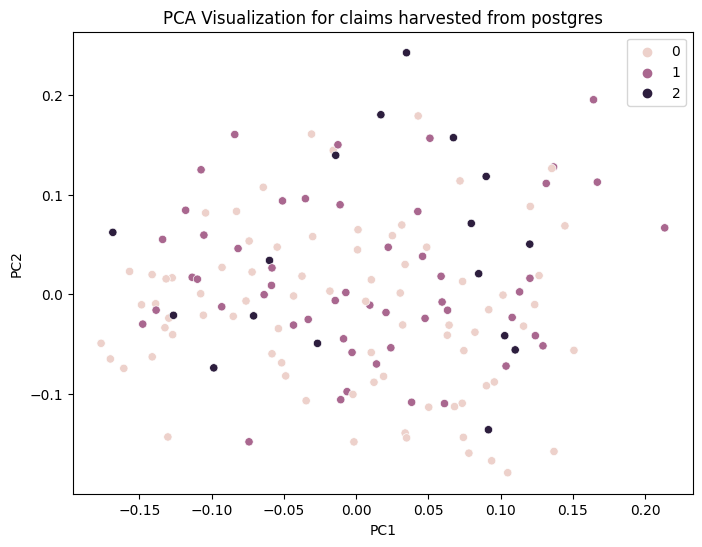

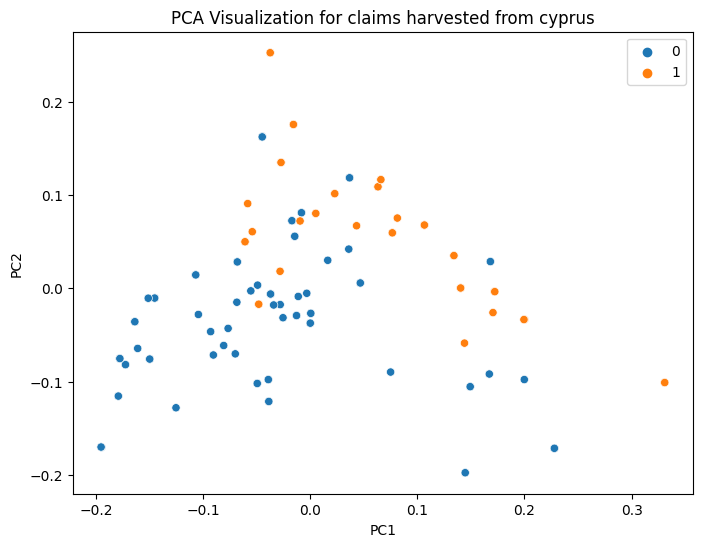

In [46]:
pca = PCA(n_components=2)
for df in train_dfs:

    df = df[df.label<=2]
    df.reset_index(drop=True, inplace=True)
    arr = [df.text_embedding[i] for i in range(len(df))]
    
    labels = [df.label[i] for i in range(len(df))]
    arr = np.array(arr, dtype=np.float64)
    pca.fit(arr)
   
    pca_res = pca.transform(arr)
    X = pca_res[:,0]
    y = pca_res[:,1]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X,y=y, hue=labels)
    plt.title(f"PCA Visualization for claims harvested from {df.source[0]}")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    

  File "c:\Users\johnk\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


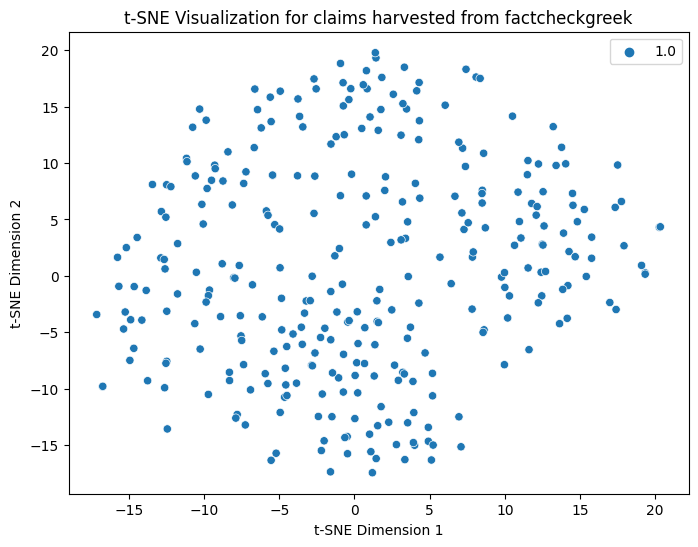

In [15]:
test = test[test.label<=2]
test.reset_index(drop=True, inplace=True)
arr = [test.text_embedding[i] for i in range(len(test))]


    
labels = [test.label[i] for i in range(len(test))]
arr = np.array(arr, dtype=np.float64)
tsne_features = m.fit_transform(arr)

m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(arr)
    

X = tsne_features[:,0]
y = tsne_features[:,1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X,y=y, hue=labels)
plt.title(f"t-SNE Visualization for claims harvested from {test.source[0]}")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [16]:
test.label.value_counts()

1.0    307
Name: label, dtype: int64